In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from ipynb.fs.defs. Convolutional_neural_network import CNN

In [2]:
PATH = "./SimpsonsCNN"
net = CNN()
net.load_state_dict(torch.load(PATH))
net

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 128, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): PReLU(num_parameters=1)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): PReLU(num_parameters=1)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): PReLU(num_parameters=

In [3]:
class_map = {"abraham_grampa_simpson": 0, "bart_simpson": 1, 
             "homer_simpson": 2, "lisa_simpson": 3, 
             "marge_simpson": 4,  "principal_skinner": 5}   

path = './Data/heatmaps/homer_simpson/pic_0001.jpg'
img = cv2.imread(path)
img = torch.tensor(img, dtype=torch.float)
img = img.permute(2,0,1).unsqueeze(0)
label = class_map[path.split('/')[-2]]

In [4]:
net.eval()
gap_weights = np.array(net.fc_layer[1].weight.detach())
parameters = np.array(torch.squeeze(net.conv_layer[:14](img)).detach())

w = 15
h = 15
d = 384

CAM = np.zeros((w, h))
for x in range(w):
    for y in range(h):
        for k in range(d):
            CAM[x][y] += gap_weights[int(label)][k] * parameters[k][x][y]

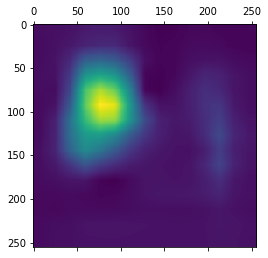

(256, 256)

In [5]:
img = cv2.imread(path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
heatmap = cv2.resize(CAM, (img.shape[1], img.shape[0]))
plt.matshow(heatmap)
plt.show()
heatmap.shape

In [6]:
heat = heatmap

In [7]:
oldMax = max(map(max, heatmap)) 
oldMin = min(map(min, heatmap)) 
newMin = 0
newMax = 255
    
for i in range(255):
    for j in range(255):
        if heatmap[i][j] > oldMax/4:
            heatmap[i][j] = (((heatmap[i][j] - oldMin) * (newMax - newMin)) / (oldMax - oldMin)) + newMin
        else:
            heatmap[i][j] = ((((heatmap[i][j] - oldMin) * (newMax - newMin)) / (oldMax - oldMin)) + newMin)/1.4

heat = heatmap

heatmap = np.uint8(1 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.85  + img
cv2.imwrite('./CAM_images/map.jpg', superimposed_img)

#

True

## Boundary box

In [8]:
left = 255
right = 0
upper = 255
lower = 0

for i in range(255):
    for j in range(255):
        if heat[i][j] > 130:
            if upper > i:
                upper = i
            if lower < i:
                lower = i
            if left > j:
                left = j
            if right < j:
                right = j

print(left,right,upper,lower)

51 111 55 135


In [11]:
img = cv2.imread(path)

flag = True
index = (0,0)
for i in range(left, right + 1):
    img[upper][i] = [0,0,0] 
    img[lower][i] = [0,0,0] 
    
    if upper > 10 and flag:
        for k in range(left, right + 1):
            for j in range(1,11):
                img[upper-j][k] = [0,0,0]
        flag = False
        index = (left + 1,upper -1)
    
    if lower < 245 and flag:
        for k in range(left, right + 1):
            for j in range(1,11):
                img[lower+j][k] = [0,0,0]
        flag = False
        index = (left + 1,lower +8)
    
for i in range(upper, lower - 1):
    img[i][left] = [0,0,0] 
    img[i][right] = [0,0,0] 

                
       
                
font  = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.3
fontColor = (255,255,255)
text = list(class_map.keys())[label].split('_')[0]
thickness = 1

cv2.putText(img, text,index,font, fontScale, fontColor, thickness )

cv2.imwrite('./CAM_images/pic_0001.jpg', img)

True